In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<h1> 1 - IOU(box, centroid)  metric should be used </h1>

<h3> YOLOV5 annotation format
    
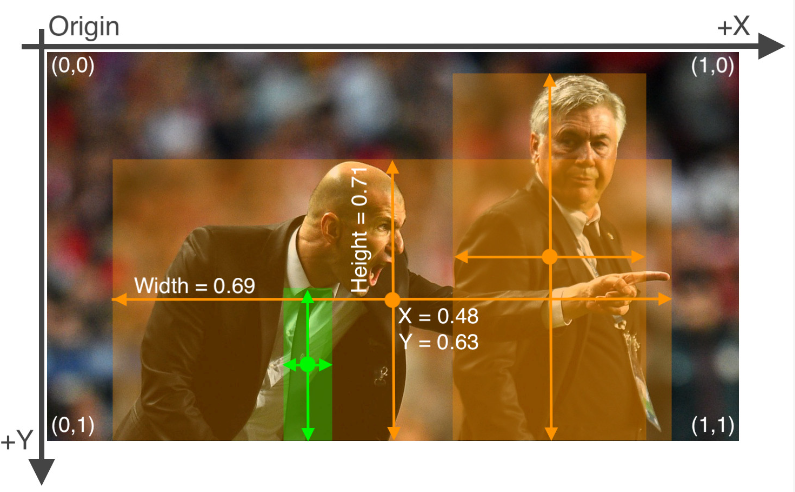
</h3>

<h2> Preprocc ideas: 

- remove highly IOU boundingboxes with same class

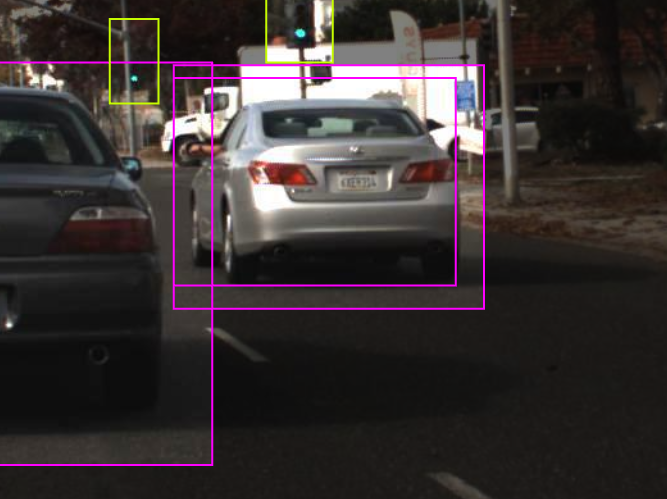

    
   

In [2]:
!pip install torchvision

import os
from IPython.display import display as dis
from IPython.display import Image as im
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import torch


from torchvision.ops import box_iou

In [3]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()

def xywh_to_xyxy(coords, scale = True):
    coords_scaled = np.zeros_like(coords)

    coords_scaled[:, 0] = coords[:, 0] - (coords[:, 2] * 0.5)
    coords_scaled[:, 1] = coords[:, 1] - (coords[:, 3] * 0.5)
    coords_scaled[:, 2] = coords[:, 0] + (coords[:, 2] * 0.5)
    coords_scaled[:, 3] = coords[:, 1] + (coords[:, 3] * 0.5)
    
    if scale:
        coords_scaled = np.round(coords_scaled).astype(int)
    
    return coords_scaled

def get_coords(labels):
    coords = []
    cls_ids = []
    i = 0

    for i in range(len(labels)):

        lpath = labels[i]
        with open(lpath, 'r') as rf:
            for line in rf.readlines():
                cls_id, x, y, w, h = list(map(float, line.split(" ")))
                x *= imw
                y *= imh
                w *= imw
                h *= imh
                coords.append([x, y, w, h])
                cls_ids.append(int(cls_id))

    coords = np.array(coords)
    cls_ids = np.array(cls_ids)
    
    return coords, cls_ids 


def get_colors(num_classes = 11, normed = False, min_brightness = 0.25):
    colorvals = [] 
    for i in range(3):
        if normed:
            colorvals+=list(((np.array(random.sample(range(num_classes), num_classes))*((256*(1-min_brightness))/num_classes)).astype(int) + (min_brightness*256))/256) #num_classes levels of brightness, 20 classes
        else:
            colorvals+=list((np.array(random.sample(range(num_classes), num_classes))*((256*(1-min_brightness))/num_classes)).astype(int) + (min_brightness*256))
    if not normed:
        colors = [(int(colorvals[x]), int(colorvals[x+1]), int(colorvals[x+2])) for x in range(0,len(colorvals), 3)]
    else:
        colors = [(colorvals[x], colorvals[x+1], colorvals[x+2]) for x in range(0,len(colorvals), 3)]
    return colors

def dot_formatter(cls_ids, packing = 4):
    unique_ids, counts = np.unique(cls_ids, return_counts = True)
    a = counts ** (1/packing)
    a = np.round(a.max() - a + a.min())
    a/=50
    colors = get_colors(len(unique_ids), normed = True)
    dot_size_dict = dict(zip(unique_ids, list(zip(a, colors[:len(a)]))))
    return dot_size_dict

def rgb_to_hex(x):
    clr = []
    for ch in x:
        clr.append(int(round(ch*256)))
    r, g, b = tuple(clr)    
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)


def optimal_kmeans(data, max_clusters=10, suptitle = "clustering for WIDTH and HEIGHT"):
    """
    Compute KMeans on a 2D numpy array and find the optimal number of clusters using silhouette and elbow methods.
    
    :param data: 2D numpy array with each data point being a pair of floats.
    :param max_clusters: Maximum number of clusters to try.
    :return: Optimal number of clusters, silhouette scores, and inertia values for different numbers of clusters.
    """
    silhouette_scores = []
    inertia_values = []
    range_n_clusters = range(2, max_clusters + 1)

    for n_clusters in range_n_clusters:
        # Initialize KMeans
        print(f"computing kmeans with {n_clusters} clusters")
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        
        # Fit the model
        cluster_labels = kmeans.fit_predict(data)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        # Calculate inertia (sum of squared distances to closest cluster center)
        inertia_values.append(kmeans.inertia_)

    # Plotting silhouette scores
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range_n_clusters, silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette Method For Optimal k')

    # Plotting the elbow method
    plt.subplot(1, 2, 2)
    plt.plot(range_n_clusters, inertia_values, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')

    plt.suptitle(suptitle, fontsize = 'x-large')
    plt.tight_layout()
    
    plt.show()

    # Finding the optimal number of clusters
    optimal_n_clusters_silhouette = np.argmax(silhouette_scores) + 2  # +2 because range starts from 2
    optimal_n_clusters_elbow = np.argmin(np.gradient(inertia_values)) + 2  # +2 for the same reason

    return optimal_n_clusters_silhouette, optimal_n_clusters_elbow, silhouette_scores, inertia_values

def centroids_same(centroids, new_centroids):
    changed = False
    centroids = centroids.numpy().astype(int).tolist()
    new_centroids = new_centroids.numpy().astype(int).tolist()
#     print(f"old_centroids : \n{centroids}\nnew_centroids : \n{new_centroids}")
    for i in range(len(centroids)):
        
        exists = False
        for j in range(len(centroids)):
            if len(set(new_centroids[i]) - set(centroids[j])) == 0:
#                 print(f"{new_centroids[i]} exists")
                exists = True
        if not exists:
#             print(f"{new_centroids[i]} DOSENT EXIST")
            changed = True
            
    return not changed 

            
def viz_centroids(centroids, cluster_ids):
    img = np.zeros([1200, 1920, 3]) 
    non_null_cluster_ids, counts = cluster_ids.unique(return_counts = True)
    colors = get_colors(len(centroids))
    viz_img = img.copy()
    for i in non_null_cluster_ids:
        x1,y1,x2,y2 = centroids[i].numpy().astype(int)
        viz_img = cv2.rectangle(viz_img, (x1,y1), (x2, y2), thickness = 10, color = colors[i])

    cv2.imwrite("temp.jpg", viz_img)
    dis(im("temp.jpg"))

def xyxy_to_xywh(coords, scale = True):
#     coords_scaled = np.zeros_like(coords)
    
    coords[:, 2] = coords[:, 2] - coords[:, 0]
    coords[:, 3] = coords[:, 3] - coords[:, 1]
    coords[:, 0] += (coords[:, 2] / 2)
    coords[:, 1] += (coords[:, 3] / 2)
    
    if scale:
        coords = np.round(coords).astype(int)
    
    return coords

def kmeans_iou(coords, num_clusters, max_iter = 200, verbose = False): #coords -> numpy.array() n * x,y,w,h
    tcoords = coords
    tcoords[:,0] = 600
    tcoords[:,1] = 600

    boxes = xywh_to_xyxy(tcoords, scale = False)

    boxes = torch.tensor(boxes)

    centroids = boxes[random.sample(range(len(coords)), num_clusters)]

    changed = True

    k_it = 0
    while(changed):

        ious = torchvision.ops.box_iou(boxes1 = boxes, boxes2= centroids)
        cluster_ids = ious.argmin(axis = 1)
        non_null_clusters, counts = cluster_ids.unique(return_counts = True)

        changed = False

        new_centroids = centroids.clone()
        for cluster_id in non_null_clusters:
            new_centroids[cluster_id] = boxes[cluster_ids == cluster_id].mean(axis = 0)

        if centroids_same(centroids, new_centroids):
            print(f"CONVERGED : centroids not changed")
            viz_centroids(new_centroids, cluster_ids)
            return new_centroids, cluster_ids
        else:
            centroids = new_centroids
            changed = True
        if verbose:
            if k_it%5==0:
                print(f"iteration : {k_it}: non null cluster ids : {non_null_clusters}, counts : {counts}")#" \ncentroids:\n{centroids}")
        k_it+=1
        
        if k_it > max_iter:
            print(f"###############\n DIDNT CONVERGE, REACHED MAX ITER \n###################")
            viz_centroids(new_centroids, cluster_ids)
            return new_centroids, cluster_ids


In [4]:
# !curl -L "https://public.roboflow.com/ds/zevPPgWqVl?key=tQOmVY5hR0" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [5]:

import os


labels_dir = "/kaggle/working/export/labels/"
images_dir = "/kaggle/working/export/images/"

labels = [os.path.join(labels_dir, x) for x in os.listdir(labels_dir)]
images = [os.path.join(images_dir, x) for x in os.listdir(images_dir)]

finder_dict = {}

for ind, image_path in enumerate(images):
    image_name = '.'.join(image_path.split("/")[-1].split(".")[:-1])
    finder_dict[image_name] = ind
                          
def find_key(x):
    x = '.'.join(x.split("/")[-1].split(".")[:-1])
    return finder_dict[x]
    
labels.sort(key = find_key)

images = np.array(images)
labels = np.array(labels)

import yaml

with open("data.yaml", 'r') as rf:
    yamldata = yaml.safe_load(rf)
    
class_names = yamldata["names"]
class_dict = dict(zip(range(len(class_names)), class_names))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/export/labels/'

<h1> viz data </h1>

In [ ]:
colors = get_colors(num_classes = 11, min_brightness = 0.1)

i = 0
for i in range(20):

    lpath = labels[i]
    ipath = images[i]
    img = cv2.imread(ipath)

    imh, imw = img.shape[:2]

    coords = []
    cls_ids = []

    with open(lpath, 'r') as rf:
        for line in rf.readlines():
            cls_id, x, y, w, h = list(map(float, line.split(" ")))
            x *= imw
            y *= imh
            w *= imw
            h *= imh
            coords.append([x, y, w, h])
            cls_ids.append(int(cls_id))

        coords = np.array(coords)
        cls_ids = np.array(cls_ids)
        
        if len(coords) <1 :
            continue
        coords = xywh_to_xyxy(coords)

    for ind, coord in enumerate(coords):
        color = colors[cls_ids[ind]]
        img = cv2.rectangle(img, (coord[0], coord[1]), (coord[2], coord[3]), color = color, thickness = 6)

    cv2.imwrite("temp.jpg", img)
    dis(im("temp.jpg"))

In [ ]:
# ##########can be removed########################
# def get_coords(labels):
#     coords = []
#     cls_ids = []
#     i = 0

#     for i in range(len(labels)):

#         lpath = labels[i]
#         with open(lpath, 'r') as rf:
#             for line in rf.readlines():
#                 cls_id, x, y, w, h = list(map(float, line.split(" ")))
#                 x *= imw
#                 y *= imh
#                 w *= imw
#                 h *= imh
#                 coords.append([x, y, w, h])
#                 cls_ids.append(int(cls_id))

#     coords = np.array(coords)
#     cls_ids = np.array(cls_ids)
    
#     return coords, cls_ids 
# ###############################################

coords, cls_ids = get_coords(labels)

# sampled_labels = random.sample(labels, int(round(len(labels)*0.1)))

sampled_inds = random.sample(range(len(labels)), int(round(len(labels)*0.1)))
sampled_labels = labels[sampled_inds]
sampled_cls_ids = cls_ids[sampled_inds]

sampled_coords, sampled_cls_ids = get_coords(sampled_labels) # 10 % of data is only considered

In [ ]:
len(cls_ids)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(cls_ids)
axs[0].set_title("full - class distribution")

axs[1].hist(sampled_cls_ids)
axs[1].set_title("sampled - class distribution")

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(24, 12))

axs[0,0].hist(coords[:,2], bins=200)
axs[0,0].set_title("full - width")

axs[0,1].hist(coords[:,3], bins = 200)
axs[0,1].set_title("full - height")

asp_rat = coords[:,2] / coords[:,3]
axs[0,2].hist(asp_rat, bins = 200)
axs[0,2].set_title("full - aspect ration (w/h)")

axs[0,3].scatter(coords[:,2], coords[:,3], s=0.01)
axs[0,3].set_title("full - scatter x = w , y = h")


axs[1,0].hist(sampled_coords[:,2], bins=200)
axs[1,0].set_title("sampled - width")

axs[1,1].hist(sampled_coords[:,3], bins = 200)
axs[1,1].set_title("sampled - height")

asp_rat = sampled_coords[:,2] / sampled_coords[:,3]
axs[1,2].hist(asp_rat, bins = 200)
axs[1,2].set_title("sampled - aspect ration (w/h)")

axs[1,3].scatter(sampled_coords[:,2], sampled_coords[:,3], s=0.01)
axs[1,3].set_title("sampled - scatter x = w , y = h")



plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline

dot_dict = dot_formatter(cls_ids)
plt.figure(figsize=(20,20))
dot_sizes = [dot_dict[x][0] for x in cls_ids]
dot_colors = [dot_dict[x][1] for x in cls_ids]

plt.scatter(coords[:,2],
            coords[:,3],
            s = dot_sizes,
            c = dot_colors)


cell_text = list([x]  for x in class_dict.values())
cell_colors = [[rgb_to_hex(x[1])] for x in dot_dict.values()]

fig, ax = plt.subplots(figsize=(3, 5))  # Adjusted for a single column

ax.axis('tight')
ax.axis('off')

table = plt.table(cellText=cell_text,
                      cellColours=cell_colors,
                      cellLoc='center',
                      loc='top left')

table.scale(1, 2)
table.auto_set_font_size(False)
table.set_fontsize(12)

plt.show()

In [ ]:
data = sampled_coords[:, 2] / sampled_coords[:, 3]  # 100 data points with 2 features each
data = data.reshape(-1,1)
optimal_n_clusters_silhouette, optimal_n_clusters_elbow, silhouette_scores, inertia_values = optimal_kmeans(data)
optimal_n_clusters_silhouette, optimal_n_clusters_elbow

<h1> Clustering with WIDTH and HEIGHT

In [ ]:
data = sampled_coords[:, 2:] # 100 data points with 2 features each
data = data.reshape(-1,1)
optimal_n_clusters_silhouette, optimal_n_clusters_elbow, silhouette_scores, inertia_values = optimal_kmeans(data, suptitle = "clustering for WIDTH and HEIGHT")
optimal_n_clusters_silhouette, optimal_n_clusters_elbow

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
data = sampled_coords[:, 2:]  # 100 data points with 2 features each
cluster_labels = kmeans.fit(data)
wh_centroids = kmeans.cluster_centers_

<h1> Clustering with ASPECT RATIO (w/h)

In [ ]:
data = sampled_coords[:, 2] / sampled_coords[:, 3]  # 100 data points with 2 features each
data = data.reshape(-1,1)
optimal_n_clusters_silhouette, optimal_n_clusters_elbow, silhouette_scores, inertia_values = optimal_kmeans(data, suptitle = "clustering for ASPECT RATIO (w/h)")
optimal_n_clusters_silhouette, optimal_n_clusters_elbow

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
data = sampled_coords[:, 2] / sampled_coords[:, 3]  # 100 data points with 2 features each
data = data.reshape(-1,1)
cluster_labels = kmeans.fit(data)
ar_centroids = kmeans.cluster_centers_

In [ ]:
%matplotlib inline

dot_dict = dot_formatter(cls_ids)
plt.figure(figsize=(20,20))
dot_sizes = [dot_dict[x][0] for x in cls_ids]
dot_colors = [dot_dict[x][1] for x in cls_ids]

plt.scatter(coords[:,2],
            coords[:,3],
            s = dot_sizes,
            c = dot_colors)

new_dot_s = []
new_dot_c = []
arh = []
arw = []
for cent in ar_centroids:
    new_dot_s += [0.7  for x in range(0,1200)]
    new_dot_c += [(0.9,0.9,0) for x in range(0,1200)]
    arh += list(range(1,1201))
    arw += [int(round(x*cent[0])) for x in range(1,1201)]
 
print(len(new_dot_s), len(new_dot_c), len(arh), len(arw))
plt.scatter(arw,
            arh,
            s = new_dot_s,
            c = new_dot_c)

for cent in wh_centroids:
    x, y = cent
    plt.scatter(x,
            y,
            s = 280,
            c = (0,0,0))
    


cell_text = list([x]  for x in class_dict.values())
cell_colors = [[rgb_to_hex(x[1])] for x in dot_dict.values()]

fig, ax = plt.subplots(figsize=(3, 5))  # Adjusted for a single column

ax.axis('tight')
ax.axis('off')

table = plt.table(cellText=cell_text,
                      cellColours=cell_colors,
                      cellLoc='center',
                      loc='top left')

table.scale(1, 2)
table.auto_set_font_size(False)
table.set_fontsize(12)

plt.show()

In [ ]:
# def kmeans_iou(coords, num_clusters, max_iter = 200, verbose = False): #coords -> numpy.array() n * x,y,w,h
#     tcoords = coords
#     tcoords[:,0] = 600
#     tcoords[:,1] = 600

#     boxes = xywh_to_xyxy(tcoords, scale = False)

#     boxes = torch.tensor(boxes)

#     centroids = boxes[random.sample(range(len(coords)), num_clusters)]

#     changed = True

#     k_it = 0
#     while(changed):

#         ious = torchvision.ops.box_iou(boxes1 = boxes, boxes2= centroids)
#         cluster_ids = ious.argmin(axis = 1)
#         non_null_clusters, counts = cluster_ids.unique(return_counts = True)

#         changed = False

#         new_centroids = centroids.clone()
#         for cluster_id in non_null_clusters:
#             new_centroids[cluster_id] = boxes[cluster_ids == cluster_id].mean(axis = 0)

#         if centroids_same(centroids, new_centroids):
#             print(f"CONVERGED : centroids not changed")
#             viz_centroids(new_centroids, cluster_ids)
#             return new_centroids, cluster_ids
#         else:
#             centroids = new_centroids
#             changed = True
#         if verbose:
#             if k_it%5==0:
#                 print(f"iteration : {k_it}: non null cluster ids : {non_null_clusters}, counts : {counts}")#" \ncentroids:\n{centroids}")
#         k_it+=1
        
#         if k_it > max_iter:
#             print(f"###############\n DIDNT CONVERGE, REACHED MAX ITER \n###################")
#             viz_centroids(new_centroids, cluster_ids)
#             return new_centroids, cluster_ids


In [ ]:
for i in range(2,20):
    kmeans_iou(coords, num_clusters = i, max_iter = 150, verbose = False)

In [ ]:
#  def viz_centroids(centroids, cluster_ids):
#     img = np.zeros([1200, 1920, 3]) 
#     non_null_cluster_ids, counts = cluster_ids.unique(return_counts = True)
#     colors = get_colors(len(centroids))
#     viz_img = img.copy()
#     for i in non_null_cluster_ids:
#         x1,y1,x2,y2 = centroids[i].numpy().astype(int)
#         viz_img = cv2.rectangle(viz_img, (x1,y1), (x2, y2), thickness = 10, color = colors[i])

#     cv2.imwrite("temp.jpg", viz_img)
#     dis(im("temp.jpg"))
